# Tutorial

This tutorial will show you the basics of training and evaluating an instance of ``globalemu``. If you are just interested in evaluating the released models then take a look at the second part towards the bottom of the page. If you are intending to work with neutral fraction histories then the frame work for training and evaluating models is identical you just need to pass the kwarg ``xHI=True`` to all of the ``globalemu`` functions.

## Training A Model

This tutorial will show you how to train a ``globalemu`` model on simulations of the Global 21-cm signal.

The first thing we need to do is download some 21-cm signal models to train our network on. For this we will use the 21cmGEM models and the following code.

In [1]:
import requests
import os
import numpy as np

data_dir = 'downloaded_data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

files = ['Par_test_21cmGEM.txt', 'Par_train_21cmGEM.txt', 'T21_test_21cmGEM.txt', 'T21_train_21cmGEM.txt']
saves = ['test_data.txt', 'train_data.txt', 'test_labels.txt', 'train_labels.txt']

for i in range(len(files)):
    url = 'https://zenodo.org/record/4541500/files/' + files[i]
    with open(data_dir + saves[i], 'wb') as f:
        f.write(requests.get(url).content)

In order for ``globalemu`` to work the training data needs to be saved in the data_dir and in the files 'train_data.txt' and 'train_labels.txt' which are the inputs and outputs of the network respectively.

Once the files have been downloaded we can go ahead and perform the preprocessing necessary for ``globalemu`` to effectively train a model. We do this with the ``process()`` function found in ``globalemu.preprocess``.

In [2]:
from globalemu.preprocess import process

base_dir = 'results/'
z = np.linspace(5, 50, 451)
num = 1000

process(num, z, base_dir=base_dir, data_location=data_dir)

Preprocessing started...
...preprocessing done.


Since this tutorial is only ment to demonstrate how to train a model with the ``globalemu`` code we are only going to pre-process 1000 models and train with 1000 models out of a possible ~24000. We do this by setting ``num=1000`` above but if we wanted to train on all the models we would set ``num='full'``.

Importantly the pre-processing function takes the data in ``data_dir`` and saves a ``.csv`` file in the ``base_dir`` containing the preprocessed inputs for the neural network. It also saves some files used for normalisation in the ``base_dir`` so that when evaluating the network the inputs and outputs can be properly dealt with.

Once pre-processing has been performed we can train our network with the ``nn()`` function in ``globalemu.network``.

In [3]:
from globalemu.network import nn

nn(batch_size=451, epochs=10, base_dir=base_dir, layer_sizes=[8])

Epoch: 000, Loss: 0.83852, RMSE: 0.90449, Time: 8.307
Epoch: 001, Loss: 0.68632, RMSE: 0.81923, Time: 7.091
Epoch: 002, Loss: 0.63357, RMSE: 0.78706, Time: 7.336
Epoch: 003, Loss: 0.57699, RMSE: 0.75084, Time: 7.959
Epoch: 004, Loss: 0.51844, RMSE: 0.71172, Time: 9.079
Epoch: 005, Loss: 0.46630, RMSE: 0.67485, Time: 8.003
Epoch: 006, Loss: 0.41997, RMSE: 0.64052, Time: 7.030
Epoch: 007, Loss: 0.37895, RMSE: 0.60875, Time: 7.776
Epoch: 008, Loss: 0.34503, RMSE: 0.58109, Time: 8.202
Epoch: 009, Loss: 0.31725, RMSE: 0.55773, Time: 7.581


``nn()`` has a bunch of keyword arguments that can be passed if required. All are documented and all have default values. However you will likely need to change things like ``base_dir`` which tells the code where the pre-processed data is and also ``layer_sizes`` which determines the network architecture. ``epochs`` is the number of training calls and often the default will be insufficient for training the network.

The code saves the model and loss history every ten epochs incase your computer crashes or the program is interrupted for some unforseen reason. If this happens or you reach the max number of epochs and need to continue training you can do the following and the code will resume from the last save.

In [4]:
nn(batch_size=451, epochs=10, base_dir=base_dir, layer_sizes=[8], resume=True)

Epoch: 000, Loss: 0.29847, RMSE: 0.54116, Time: 7.161
Epoch: 001, Loss: 0.28018, RMSE: 0.52442, Time: 6.985
Epoch: 002, Loss: 0.26387, RMSE: 0.50901, Time: 7.283
Epoch: 003, Loss: 0.24978, RMSE: 0.49561, Time: 6.854
Epoch: 004, Loss: 0.23778, RMSE: 0.48355, Time: 6.836
Epoch: 005, Loss: 0.22754, RMSE: 0.47307, Time: 6.882
Epoch: 006, Loss: 0.21902, RMSE: 0.46419, Time: 6.837
Epoch: 007, Loss: 0.21148, RMSE: 0.45612, Time: 6.913
Epoch: 008, Loss: 0.20443, RMSE: 0.44844, Time: 6.821
Epoch: 009, Loss: 0.19794, RMSE: 0.44116, Time: 6.744


You have now successfully trained an instance of globalemu.

## Evaluating Your Model

We can go ahead and evaluate the model using the testing data that we downloaded earlier.

In [5]:
test_data = np.loadtxt(data_dir + 'test_data.txt')
test_labels = np.loadtxt(data_dir + 'test_labels.txt')

With the data loaded we will look at how the model performs when predicting the first signal in the data set. We do this with the ``evaluate()`` function in ``globalemu.eval`` which takes in a set of parameters and returns a signal. We also supply a ``base_dir`` which contains the pre-processed data, normalisation factors and trained model. For multiple calls it is quicker to pass the trained model directly and their exists a kwarg in order to do this however we leave this for now. You can also pass a redshift range with the ``z`` kwarg however if this isn't supplied than the function will return the signal at the original redshifts that were used for training.

Text(0.5, 0, '$z$')

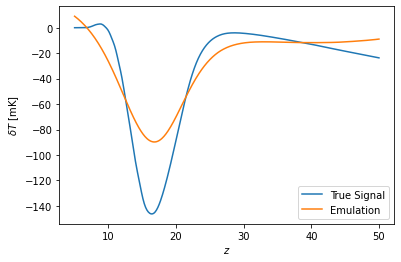

In [6]:
from globalemu.eval import evaluate

input_params = test_data[0, :]
true_signal = test_labels[0, :]

res = evaluate(input_params, base_dir=base_dir)

import matplotlib.pyplot as plt

plt.plot(z, true_signal, label='True Signal')
plt.plot(res.z, res.signal, label='Emulation')
plt.legend()
plt.ylabel(r'$\delta T$ [mK]')
plt.xlabel(r'$z$')

The emulation is pretty poor for several reasons; we didn't run the training for long enough (only 20 epochs), the network size is small and we used very little of the available training data.

We can have a look at the same signal emulated with the released model on github. This was trained with a much more appropriately sized network, the full training data and a few hundred epochs. The results are therefore more similar to the true signal.

Text(0.5, 0, '$z$')

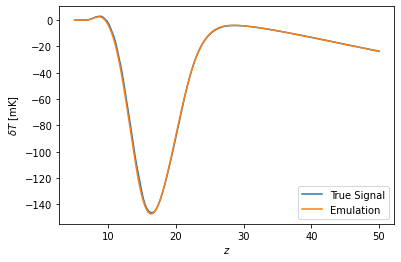

In [7]:
res = evaluate(input_params, base_dir='../T_release/')

import matplotlib.pyplot as plt

plt.plot(z, true_signal, label='True Signal')
plt.plot(res.z, res.signal, label='Emulation')
plt.legend()
plt.ylabel(r'$\delta T$ [mK]')
plt.xlabel(r'$z$')